## 1. 데이터 준비

### 데이터 로드
- UserId가 SessionId 역할
- Rating 정보 활용(Rating이 낮은 데이터의 처리 여부 고민)
- Time이 UTC time으로 기재: 1970년 1월 1일부터 경과된 초단위 시간

In [1]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

data_path = Path(os.getenv('HOME') + '/project/aiffel/e/e23/ml-1m')
train_path = data_path / 'ratings.dat'

def load_data(data_path:Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], 
                       dtype={0: np.int32, 1:np.int32, 2:np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### 데이터 전처리
- 항목별 기본 분석
- session length, session time, cleaning

### User Length
- 각 유저가 대략 몇개의 Rating을 갖는가?

In [2]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [3]:
user_length = data.groupby('UserId').size()

user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [4]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [5]:
user_length.min(), user_length.max()

(20, 2314)

In [6]:
user_length.quantile(0.999)

1343.181000000005

In [7]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId'] == long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


가장 긴 length를 가진 유저를 살펴보면 초단위로 리뷰를 작성하고 있음을 알 수 있다

In [8]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

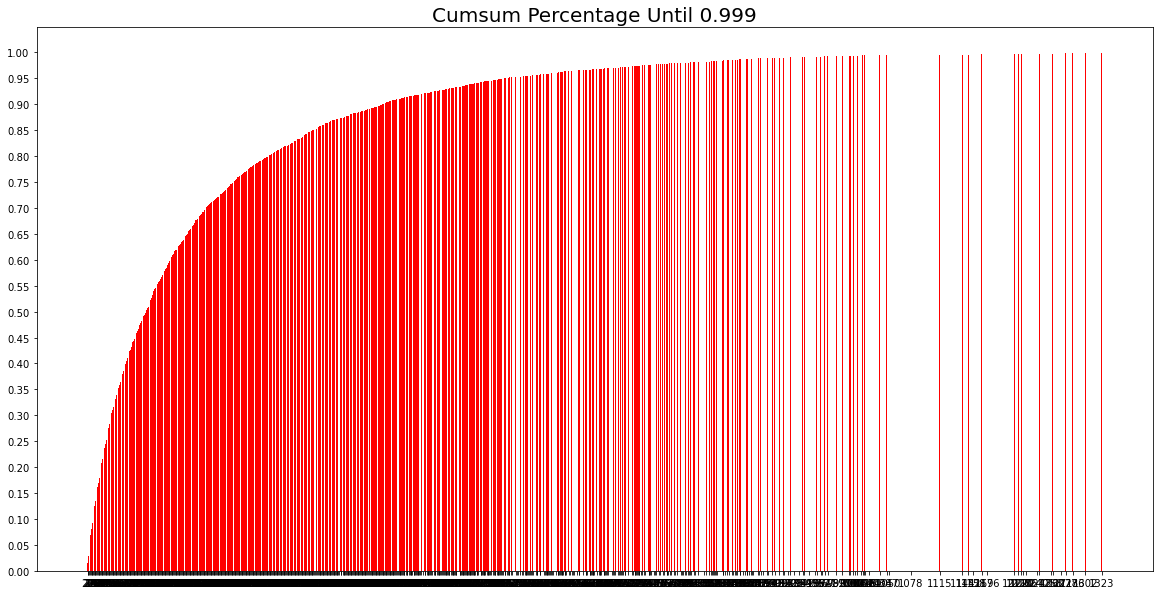

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
       height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### User time
- 각 유저의 Rating이 발생한 시간은?

In [10]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [11]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

### Data Cleansing

In [12]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_rated) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, shortest)
        data = cleanse_unpopular_item(data, least_rated)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_user(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_rated):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_rated].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [13]:
data = cleanse_recursive(data, shortest=5, least_rated=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [14]:
data = data.sort_values(by=['Time'])

### Train/ Valid/ Test split

In [15]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    #user_in_train = user_last_time[user_last_time < final_time - dt.timedelta(n_days)].index
    #user_in_test = user_last_time[user_last_time >= final_time - dt.timedelta(n_days)].index
    
    #before_date = data[data['UserId'].isin(user_in_train)]
    #after_date = data[data['UserId'].isin(user_in_test)]
    #after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])] 
    return user_in_train, user_in_test
    

In [41]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [42]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'*{status} Set Stats Info \n'
         f'\t Events: {len(data)} \n'
         f'\t Users: {data["UserId"].nunique()}\n'
         f'\t Items: {data["ItemId"].nunique()}\n'
         f'\t First Time: {data["Time"].min()}\n'
         f'\t Last Time: {data["Time"].max()}\n')

In [43]:
stats_info(tr, 'train')

*train Set Stats Info 
	 Events: 978534 
	 Users: 6038
	 Items: 3416
	 First Time: 2000-04-25 23:05:32
	 Last Time: 2002-03-05 04:19:56



In [44]:
stats_info(val, 'valid')

*valid Set Stats Info 
	 Events: 12271 
	 Users: 399
	 Items: 2606
	 First Time: 2002-03-05 04:21:07
	 Last Time: 2002-09-01 04:20:59



In [45]:
stats_info(test, 'test')

*test Set Stats Info 
	 Events: 8806 
	 Users: 339
	 Items: 2317
	 First Time: 2002-09-01 19:41:39
	 Last Time: 2003-02-28 17:49:50



In [46]:
id2idx = {item_id: index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [47]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'triain.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 2. 미니 배치 구성
- Session-Parallel Mini-Batch 개념에 따라 학습 속도의 저하가 최소화될 수 있도록
- Session 단위를 어떻게 정의했느냐에 따라 필요 없을 수 있음

### UserDataset

In [48]:
class UserDataset:
    
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())
    
    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [24]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [25]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 965986, 966109, 966450], dtype=int32)

In [26]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 6034, 6035, 6036])

### UserDataLoader

In [27]:
class UserDataLoader:
    
    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size
    
    def __iter__(self):
        start, end, mask, last_user, finished = self.initialize()
        
        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask
            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)
        
    def initialize(self):
        first_iters = np.arange(self.batch_size)
        last_user = self.batch_size - 1
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]
        mask = np.array([])
        finished = False
        return start, end, mask, last_user, finished
    
    def update_status(self, start:np.ndarray, end:np.ndarray, min_len:int, last_user:int, finished:bool):
        
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]
        
        for i, idx in enumerate(mask, start=1):
            new_user = last_user + i
            if new_user > self.dataset.user_idx[-1]:
                finished = True
                break
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]
        
        last_user += len(mask)
        return start, end, mask, last_user, finished
            

In [28]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [29]:
iter_ex = iter(tr_data_loader)

In [30]:
inputs, labels, mask = next(iter_ex)
print(f'Model Input Item Idx are: {inputs}')
print(f'Label Item Idx are: {"":5}{labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are: [  0  53 177 210]
Label Item Idx are:      [  1  54 106 211]
Previous Masked Input Idx are []


## 3. 모델 구성

### Evaluation Metric

In [36]:
def mrr_k(pred, truth:int, k:int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth:int, k:int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test= test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
    

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
    

In [50]:
model = create_model(args)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_2 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [51]:
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)
    
    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)
            
            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)
            
            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy=result[1])
        
        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)
        
        print(f"\t - Recall@{args.k} epoch{epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k} epoch{epoch}: {val_mrr:3f}\n")
    

def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name="GRU")
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)

def get_metrics(data, model, args, k:int):
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []
    
    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        
        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')
        
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])
    
    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [52]:
train_model(model, args)

Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0, train_loss=6.84]      

	 - Recall@20 epoch1: 0.051897
	 - MRR@20 epoch1: 0.010515



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.51] 

	 - Recall@20 epoch2: 0.067522
	 - MRR@20 epoch2: 0.017177



Evaluation:  15%|█▌        | 7/46 [00:04<00:27,  1.43it/s]

	 - Recall@20 epoch3: 0.082589
	 - MRR@20 epoch3: 0.018500



## 4. 모델 학습
- Recall, MRR 등의 개념 관리

### model_1

In [53]:
args_1 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=20, k=10)
model_1 = create_model(args_1)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout_3 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [55]:
train_model(model_1, args_1)

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.28]

	 - Recall@10 epoch1: 0.060595
	 - MRR@10 epoch1: 0.021128



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.31]

	 - Recall@10 epoch2: 0.064215
	 - MRR@10 epoch2: 0.024166



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.28] 

	 - Recall@10 epoch3: 0.064024
	 - MRR@10 epoch3: 0.022010



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.36] 

	 - Recall@10 epoch4: 0.062500
	 - MRR@10 epoch4: 0.022670



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.26] 

	 - Recall@10 epoch5: 0.063072
	 - MRR@10 epoch5: 0.021529



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.31] 

	 - Recall@10 epoch6: 0.062119
	 - MRR@10 epoch6: 0.022252



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.38] 

	 - Recall@10 epoch7: 0.061357
	 - MRR@10 epoch7: 0.022794



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.32]

	 - Recall@10 epoch8: 0.062309
	 - MRR@10 epoch8: 0.021046



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.38] 

	 - Recall@10 epoch9: 0.059070
	 - MRR@10 epoch9: 0.022008



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.32] 

	 - Recall@10 epoch10: 0.063072
	 - MRR@10 epoch10: 0.022077



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.26] 

	 - Recall@10 epoch11: 0.059832
	 - MRR@10 epoch11: 0.020661



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.39] 

	 - Recall@10 epoch12: 0.060976
	 - MRR@10 epoch12: 0.021369



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.29] 

	 - Recall@10 epoch13: 0.058117
	 - MRR@10 epoch13: 0.021179



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.42] 

	 - Recall@10 epoch14: 0.061166
	 - MRR@10 epoch14: 0.021810



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.3]  

	 - Recall@10 epoch15: 0.058880
	 - MRR@10 epoch15: 0.021376



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.47] 

	 - Recall@10 epoch16: 0.055831
	 - MRR@10 epoch16: 0.019936



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.17] 

	 - Recall@10 epoch17: 0.061928
	 - MRR@10 epoch17: 0.022569



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.29] 

	 - Recall@10 epoch18: 0.054497
	 - MRR@10 epoch18: 0.019291



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.31] 

	 - Recall@10 epoch19: 0.060023
	 - MRR@10 epoch19: 0.021928



Evaluation:  45%|████▍     | 41/92 [00:08<00:11,  4.63it/s]

	 - Recall@10 epoch20: 0.060404
	 - MRR@10 epoch20: 0.021127



### model_2

In [56]:
args_2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.003, epochs=20, k=20)
model_2 = create_model(args_2)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout_4 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_4 (Dense)              (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [57]:
train_model(model_2, args_2)

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.48]

	 - Recall@20 epoch1: 0.101753
	 - MRR@20 epoch1: 0.023867



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.32] 

	 - Recall@20 epoch2: 0.107660
	 - MRR@20 epoch2: 0.027950



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.34] 

	 - Recall@20 epoch3: 0.107660
	 - MRR@20 epoch3: 0.028790



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.26]

	 - Recall@20 epoch4: 0.110328
	 - MRR@20 epoch4: 0.027910



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.28] 

	 - Recall@20 epoch5: 0.108994
	 - MRR@20 epoch5: 0.029481



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.22] 

	 - Recall@20 epoch6: 0.108232
	 - MRR@20 epoch6: 0.029249



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.33] 

	 - Recall@20 epoch7: 0.107088
	 - MRR@20 epoch7: 0.029187



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.29]

	 - Recall@20 epoch8: 0.107470
	 - MRR@20 epoch8: 0.028699



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.2]  

	 - Recall@20 epoch9: 0.106898
	 - MRR@20 epoch9: 0.028393



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.05] 

	 - Recall@20 epoch10: 0.104802
	 - MRR@20 epoch10: 0.027953



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.18] 

	 - Recall@20 epoch11: 0.103849
	 - MRR@20 epoch11: 0.028228



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.2]  

	 - Recall@20 epoch12: 0.105183
	 - MRR@20 epoch12: 0.028137



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.07] 

	 - Recall@20 epoch13: 0.104992
	 - MRR@20 epoch13: 0.028299



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.21]

	 - Recall@20 epoch14: 0.105373
	 - MRR@20 epoch14: 0.027849



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.1]  

	 - Recall@20 epoch15: 0.104230
	 - MRR@20 epoch15: 0.028652



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.52] 

	 - Recall@20 epoch16: 0.103277
	 - MRR@20 epoch16: 0.028225



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.43] 

	 - Recall@20 epoch17: 0.098895
	 - MRR@20 epoch17: 0.027976



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0234, train_loss=5.98] 

	 - Recall@20 epoch18: 0.102325
	 - MRR@20 epoch18: 0.028222



Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.96] 

	 - Recall@20 epoch19: 0.103277
	 - MRR@20 epoch19: 0.028047



Evaluation:  45%|████▍     | 41/92 [00:13<00:17,  2.99it/s]

	 - Recall@20 epoch20: 0.103087
	 - MRR@20 epoch20: 0.028269



### model_3

In [58]:
args_3 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.005, epochs=20, k=20)
model_3 = create_model(args_3)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_5 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [59]:
train_model(model_3, args_3)

Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.28]

	 - Recall@20 epoch1: 0.083147
	 - MRR@20 epoch1: 0.016733



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.2]  

	 - Recall@20 epoch2: 0.090960
	 - MRR@20 epoch2: 0.020911



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.12] 

	 - Recall@20 epoch3: 0.090402
	 - MRR@20 epoch3: 0.021445



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.11] 

	 - Recall@20 epoch4: 0.090402
	 - MRR@20 epoch4: 0.023321



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0352, train_loss=6.11] 

	 - Recall@20 epoch5: 0.090960
	 - MRR@20 epoch5: 0.021959



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0273, train_loss=6.09] 

	 - Recall@20 epoch6: 0.089844
	 - MRR@20 epoch6: 0.021845



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.06] 

	 - Recall@20 epoch7: 0.088170
	 - MRR@20 epoch7: 0.022401



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0352, train_loss=6.18] 

	 - Recall@20 epoch8: 0.085379
	 - MRR@20 epoch8: 0.022612



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.18]

	 - Recall@20 epoch9: 0.085379
	 - MRR@20 epoch9: 0.022935



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.12]

	 - Recall@20 epoch10: 0.089844
	 - MRR@20 epoch10: 0.023689



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0117, train_loss=6.07]

	 - Recall@20 epoch11: 0.088170
	 - MRR@20 epoch11: 0.023702



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.06] 

	 - Recall@20 epoch12: 0.084263
	 - MRR@20 epoch12: 0.023884



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.06]

	 - Recall@20 epoch13: 0.088728
	 - MRR@20 epoch13: 0.023569



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.14]

	 - Recall@20 epoch14: 0.087612
	 - MRR@20 epoch14: 0.023738



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.08] 

	 - Recall@20 epoch15: 0.089286
	 - MRR@20 epoch15: 0.024497



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.06]

	 - Recall@20 epoch16: 0.089844
	 - MRR@20 epoch16: 0.022748



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0273, train_loss=6.09]

	 - Recall@20 epoch17: 0.088170
	 - MRR@20 epoch17: 0.023782



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.1] 

	 - Recall@20 epoch18: 0.085938
	 - MRR@20 epoch18: 0.023001



Train:   0%|          | 0/3798 [00:00<?, ?it/s, accuracy=0.0273, train_loss=6.15] 

	 - Recall@20 epoch19: 0.091518
	 - MRR@20 epoch19: 0.022938



Evaluation:  15%|█▌        | 7/46 [00:04<00:26,  1.49it/s]

	 - Recall@20 epoch20: 0.093750
	 - MRR@20 epoch20: 0.023362



## 5. 모델 테스트
- 미리 구성된 테스트셋을 바탕으로 Recall, MRR 확인

In [61]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model_1, args_1, test)

Evaluation:  36%|███▋      | 24/66 [00:08<00:14,  2.85it/s]

	 - Recall@10: 0.123698
	 - MRR@10: 0.029320



In [62]:
test_model(model_2, args_2, test)

Evaluation:  36%|███▋      | 24/66 [00:08<00:14,  2.90it/s]

	 - Recall@20: 0.125977
	 - MRR@20: 0.033288



In [63]:
test_model(model_3, args_3, test)

Evaluation:   6%|▌         | 2/33 [00:01<00:21,  1.43it/s]

	 - Recall@20: 0.080078
	 - MRR@20: 0.020578



### Report
- model_1: batch_size: 128, lr: 0.01, k=10
- model_2: batch_size: 128, lr: 0.003, k=20
- model_3: batch_size: 256, lr: 0.005, k=20  

각 모델이 큰 차이가 보이지 않고, recall 및 mmr이 너무 낮게 나왔다.  
크게 학습이 되지 않는 느낌이었는데, 데이터 처리하는 과정에서 rating이 반영되지 않은 것 같다.